In [2]:
# Importing key libraries 
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults 
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,d,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse,mse
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [23]:
df = pd.read_excel('QV_GDP.xlsx', index_col='Period', parse_dates=True)

In [28]:
# Set "date" to be the index
df.index.freq = 'Q'
df.head()

,GDP
Period,
Q1/1995,3560.6
Q2/1995,4141.4
Q3/1995,3883.0
Q4/1995,3724.2
Q1/1996,4008.7


TypeError: index type not supported

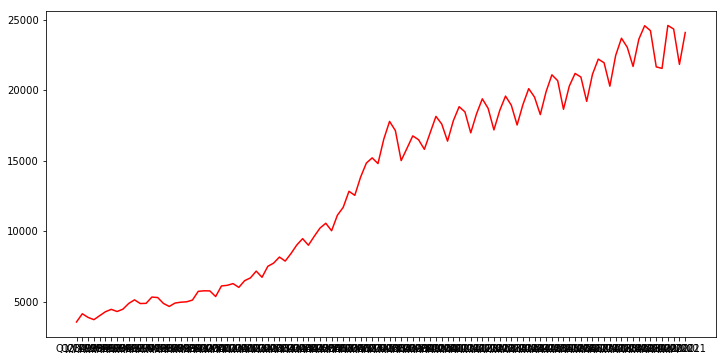

In [29]:
title='Vývoj štvrťročného HDP SR od Q1/1995 do Q2/2021'
ylabel='v mil. €'
xlabel='Štvrťrok'

ax = df.plot(figsize=(12,6),title=title, grid=True, c='red')
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.autoscale(axis='x',tight=True);

In [21]:
result = seasonal_decompose(df['GDP'], model='multiplicative')
result.plot();

AttributeError: 'Index' object has no attribute 'inferred_freq'

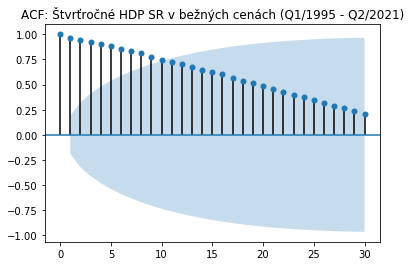

In [8]:
title = 'ACF: Štvrťročné HDP SR v bežných cenách (Q1/1995 - Q2/2021)'
lags = 30
plot_acf(df['GDP'],title=title,lags=lags);

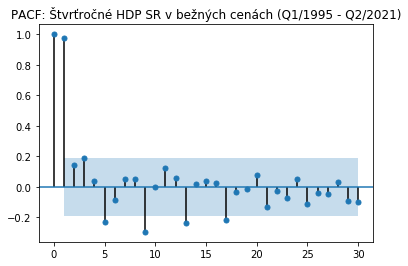

In [9]:
title = 'PACF: Štvrťročné HDP SR v bežných cenách (Q1/1995 - Q2/2021)'
lags = 30
plot_pacf(df['GDP'],title=title,lags=lags);

In [10]:
adf_test(df['GDP'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -0.408943
p-value                  0.908595
# lags used             12.000000
# observations          93.000000
critical value (1%)     -3.502705
critical value (5%)     -2.893158
critical value (10%)    -2.583637
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


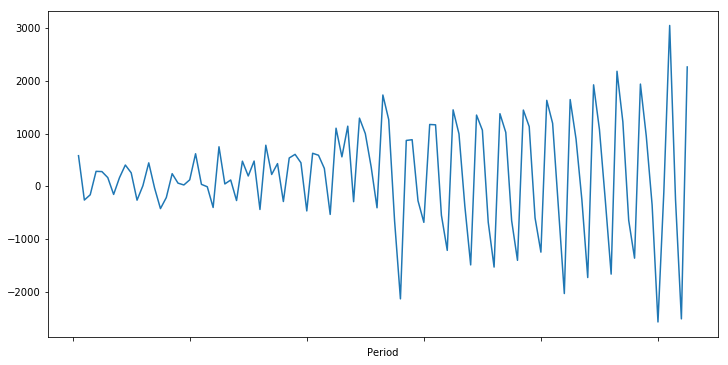

In [11]:
#Differencing data due to non stationarity - 1st difference
df['d1'] = diff(df['GDP'],k_diff=1)
df['d1'].plot(figsize=(12,6));

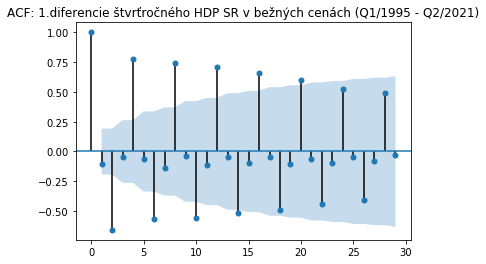

In [12]:
#ACF plot for 1st difference
title='ACF: 1.diferencie štvrťročného HDP SR v bežných cenách (Q1/1995 - Q2/2021)'
lags=30
plot_acf(df['d1'].dropna(),title=title,lags=np.arange(lags));

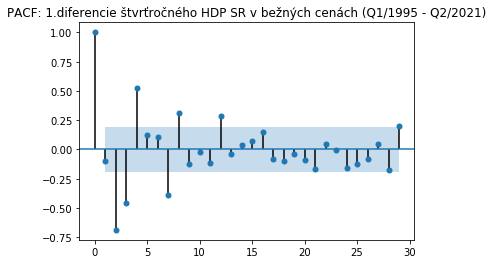

In [13]:
#PACF plot for 1st difference
title='PACF: 1.diferencie štvrťročného HDP SR v bežných cenách (Q1/1995 - Q2/2021)'
lags=30
plot_pacf(df['d1'].dropna(),title=title,lags=np.arange(lags));

In [14]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.679967
p-value                  0.077569
# lags used              7.000000
# observations          97.000000
critical value (1%)     -3.499637
critical value (5%)     -2.891831
critical value (10%)    -2.582928
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


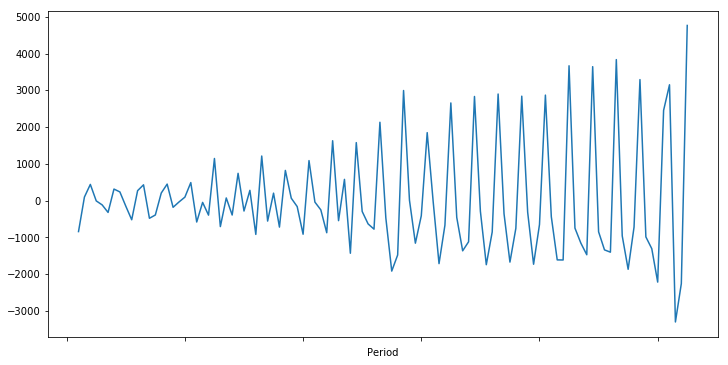

In [15]:
#Differencing data due to non stationarity - 2nd difference
df['d2'] = diff(df['GDP'],k_diff=2)
df['d2'].plot(figsize=(12,6));

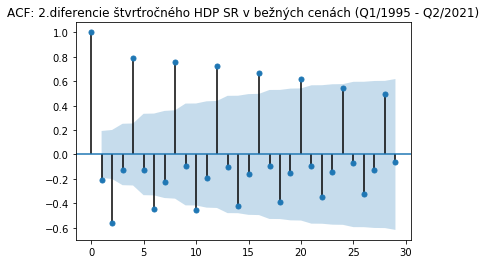

In [16]:
#ACF plot for 1st difference
title='ACF: 2.diferencie štvrťročného HDP SR v bežných cenách (Q1/1995 - Q2/2021)'
lags=30
plot_acf(df['d2'].dropna(),title=title,lags=np.arange(lags));

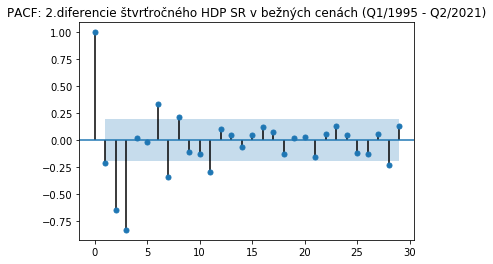

In [17]:
#PACF plot for 1st difference
title='PACF: 2.diferencie štvrťročného HDP SR v bežných cenách (Q1/1995 - Q2/2021)'
lags=30
plot_pacf(df['d2'].dropna(),title=title,lags=np.arange(lags));

In [19]:
adf_test(df['d2'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.158016
p-value                  0.000011
# lags used             10.000000
# observations          93.000000
critical value (1%)     -3.502705
critical value (5%)     -2.893158
critical value (10%)    -2.583637
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
#Running auto_arima function which measures many different models, do the differencing on its own

stepwise_fit = auto_arima(df['GDP'], start_P=1, D=None, start_Q=1,
                          seasonal=True,
                          test='adf',
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1641.902, BIC=1657.826, Fit time=0.472 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1756.812, BIC=1762.120, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1757.828, BIC=1765.790, Fit time=0.031 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1740.098, BIC=1748.060, Fit time=0.138 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1728.362, BIC=1741.632, Fit time=0.216 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1631.030, BIC=1649.608, Fit time=0.439 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1634.405, BIC=1650.328, Fit time=0.460 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1684.175, BIC=1697.444, Fit time=0.334 seconds
Fit ARIMA: order=(4, 1, 3) seasonal_order=(0, 0, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -808.515
Date:                Mon, 07 Mar 2022   AIC                           1631.030
Time:                        11:17:54   BIC                           1649.608
Sample:                             0   HQIC                          1638.558
                                - 106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    550.0768    121.969      4.510      0.000     311.022     789.132
ar.L1         -0.5330      0.103     -5.160      0.000      -0.736      -0.331
ar.L2         -0.9812      0.020    -49.962      0.000      -1.020      -0.943
ar.L3         -0.5320      0.100     -5.299      0.000      -0.729      -0.335
ma.L1          0.1502      0.069      2.163      0.031       0.014       0.286
ma.L2          0.7401      0.079      9.319      0.000       0.584       0.896
sigma2      2.773e+05   3.19e+04      8.679      0.000    2.15e+05     3.4e+05
===================================================================================
Ljung-Box (Q):                       77.08   Jarque-Bera (JB):                25.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.51   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""